# Project#2



Using only NumPy and Pandas create a Neural Network from scratch(90 pt)
<br> Set network architecture as follows:
* Implement input, hidden, and output layers concerning input-output shape.
* Define activation function.
* Implement FeedForward
* Implement BackPropagation
* Implement Train and Test functions.




Test your model on both datasets then calculate the confusion matrix and accuracy (10 pt)
* IRIS dataset
* MNIST Dataset


# Bonus( 5 pt)
1- Compare your model with the Sklearn neural network https://scikit-learn.org/stable/modules/neural_networks_supervised.html#.

2- Compare your model with the Keras neural network model.


**Import needed packages**

In [193]:
#importing neeeded libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

**Neural Network Architicture**


In [194]:
#implementing the neural network

class NN:
    """
    Neural Network class that represents a feedforward neural network.

    Attributes:
    - layers: List of layers in the neural network.
    - parameters: Dictionary of parameters (weights and biases) for each layer.
    - grads: Dictionary of gradients for each layer.
    - forward_caches: Dictionary of intermediate values during forward propagation.

    Methods:
    - add(layer): Adds a layer to the neural network.
    - _add_first_layer(layer): Adds the first layer to the neural network.
    - _add_subsequent_layer(layer): Adds a subsequent layer to the neural network.
    - forward_prop(X): Performs forward propagation on the input X.
    - back_prop(Y, alpha): Performs back propagation to update the parameters.
    - _compute_delta(l, activation): Computes the delta for a given layer during back propagation.
    - _update_parameters(alpha): Updates the parameters (weights and biases) using the computed gradients.
    - fit(X, y, epoch, learning_rate, multiclass=False): Trains the neural network on the input data.
    - predict(X): Performs forward propagation to make predictions on the input X.
    """
    def __init__(self):
        self.layers = []
        self.parameters = {}
        self.grads = {}
        self.forward_caches = {}

    def add(self, layer):
        """
        Adds a layer to the neural network.

        Args:
        - layer: The layer to be added.

        Raises:
        - ValueError: If the input shape is not specified for the first layer.
        """
        if not self.layers:
            if layer.input_shape is None:
                raise ValueError("Specify input shape (number of features)")
            self._add_first_layer(layer)
        else:
            self._add_subsequent_layer(layer)

    def _add_first_layer(self, layer):
        """
        Adds the first layer to the neural network.

        Args:
        - layer: The first layer to be added.
        """
        self.layers.append(layer)
        layer.initialize_weights()
        self.parameters['W1'] = layer.W
        self.parameters['b1'] = layer.bias

    def _add_subsequent_layer(self, layer):
        """
        Adds a subsequent layer to the neural network.

        Args:
        - layer: The subsequent layer to be added.

        Raises:
        - ValueError: If the input shape of the subsequent layer does not match the output shape of the previous layer.
        """
        prev_length = self.layers[-1].length
        layer.set_input_shape(prev_length)
        self.layers.append(layer)
        layer.initialize_weights()
        t = len(self.layers)
        self.parameters[f'W{t}'] = layer.W
        self.parameters[f'b{t}'] = layer.bias

    def forward_prop(self, X):
        """
        Performs forward propagation on the input X.

        Args:
        - X: The input data.

        Updates the forward_caches dictionary with intermediate values during forward propagation.
        """
        self.forward_caches['A0'] = X
        for i, layer in enumerate(self.layers, start=1):
            activation = layer.activation_function
            Z = np.dot(self.forward_caches[f'A{i-1}'], self.parameters[f'W{i}']) + self.parameters[f'b{i}']
            A = activation_functions(activation, Z)
            self.forward_caches[f'Z{i}'] = Z
            self.forward_caches[f'A{i}'] = A

    def back_prop(self, Y, alpha):
        """
        Performs back propagation to update the parameters.

        Args:
        - Y: The target output.
        - alpha: The learning rate.

        Updates the grads dictionary with gradients for each layer.
        """
        L = len(self.layers)
        AL = self.forward_caches[f'A{L}']
        self.grads[f'delta{L}'] = (Y - AL) * back_sigmoid(AL)

        for l in reversed(range(1, L)):
            activation = self.layers[l - 1].activation_function
            self._compute_delta(l, activation)

        self._update_parameters(alpha)
        self.grads = {}
        self.forward_caches = {}

    def _compute_delta(self, l, activation):
        """
        Computes the delta for a given layer during back propagation.

        Args:
        - l: The layer index.
        - activation: The activation function of the layer.
        """
        if activation == 'sigmoid':
            self.grads[f'delta{l}'] = np.dot(self.grads[f'delta{l+1}'], self.parameters[f'W{l+1}'].T) * back_sigmoid(self.forward_caches[f'A{l}'])
        else:
            self.grads[f'delta{l}'] = np.dot(self.grads[f'delta{l+1}'], self.parameters[f'W{l+1}'].T) * back_relu(self.forward_caches[f'Z{l}'])

    def _update_parameters(self, alpha):
        """
        Updates the parameters (weights and biases) using the computed gradients.

        Args:
        - alpha: The learning rate.
        """
        for i in range(1, len(self.layers) + 1):
            self.parameters[f'W{i}'] += np.dot(self.forward_caches[f'A{i-1}'].T, self.grads[f'delta{i}']) * alpha
            self.parameters[f'b{i}'] += np.sum(self.grads[f'delta{i}'], axis=0, keepdims=True) * alpha

    def fit(self, X, y, epoch, learning_rate, multiclass=False):
        """
        Trains the neural network on the input data.

        Args:
        - X: The input data.
        - y: The target output.
        - epoch: The number of training epochs.
        - learning_rate: The learning rate.
        - multiclass: Whether the problem is a multiclass classification problem.

        Prints the iteration number every 100 epochs.
        """
        cost_history = []
        for i in range(epoch):
            self.forward_prop(X)
            self.back_prop(y, learning_rate)
            # if i % 100 == 0 or i == epoch - 1:
            #     print(f'Iteration {i}')

    def predict(self, X):
        """
        Performs forward propagation to make predictions on the input X.

        Args:
        - X: The input data.

        Returns:
        - The predicted output.
        """
        self.forward_prop(X)
        return self.forward_caches[f'A{len(self.layers)}']

class Layer:
    def __init__(self, input_shape=None, length=1, activation_function='relu'):
        """
        Initializes a Layer object.

        Parameters:
        - input_shape (int): The shape of the input data. Default is None.
        - length (int): The number of neurons in the layer. Default is 1.
        - activation_function (str): The activation function to be used in the layer. Default is 'relu'.
        """
        self.length = length
        self.activation_function = activation_function
        self.input_shape = input_shape

    def initialize_weights(self):
        """
        Initializes the weights and biases of the layer.
        """
        np.random.seed(42)
        self.W = np.random.randn(self.input_shape, self.length)
        self.bias = np.zeros((1, self.length))

    def set_input_shape(self, num):
        """
        Sets the input shape of the layer.

        Parameters:
        - num (int): The shape of the input data.
        """
        self.input_shape = num

def activation_functions(activation_function, Z):
    """
    Applies the specified activation function to the given input.

    Parameters:
    activation_function (str): The activation function to apply. Valid options are 'sigmoid' and 'relu'.
    Z (numpy.ndarray): The input to the activation function.

    Returns:
    numpy.ndarray: The output of the activation function.
    """
    if activation_function == 'sigmoid':
        z = np.clip(Z, -500, 500)
        A = 1 / (1 + np.exp(-z))
        return A
    elif activation_function == 'relu':
        A = np.maximum(0, Z)
        return A

def back_sigmoid(outL):
    return outL * (1 - outL)

def back_relu(Z):
    return np.array(Z > 0, dtype='float')


### Iris Dataset

**PreProcessing**

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [196]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [197]:
# #PLotting the data
# sns.pairplot(df, hue='target', palette='Set1')
# plt.show()

In [198]:
# Standardize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode the target variable (for multiclass classification)
num_classes = len(np.unique(y))
y_one_hot = np.eye(num_classes)[y.reshape(-1)]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


In [199]:
# Define the neural network architecture
input_size = X_train.shape[1]
output_size = num_classes

# Create the neural network
nn = NN()
nn.add(Layer(input_shape=input_size, length=8, activation_function='sigmoid'))
nn.add(Layer(length=output_size, activation_function='sigmoid'))

# Train the neural network
epochs = 10000
learning_rate = 0.01
nn.fit(X_train, y_train, epochs, learning_rate, multiclass=True)

In [200]:
# Make predictions on the test set
predictions = nn.predict(X_test)

# Convert one-hot encoded predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

Accuracy: 100.00%
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


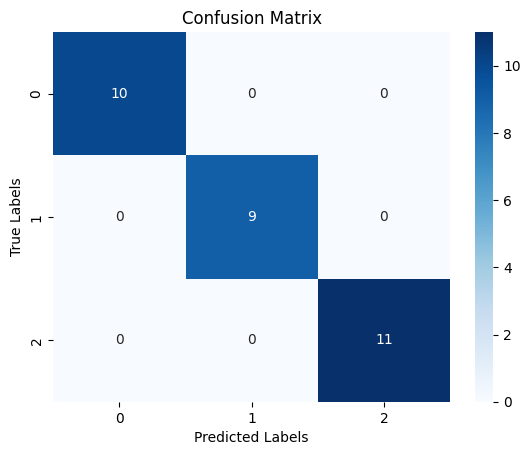

In [201]:
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Iris  with Sklearn Neural Network


In [202]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a multi-layer perceptron (MLP) classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Train the classifier on the training data
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp_classifier.predict(X_test)

# Evaluate the accuracy of the models
accuracy_sklearn = accuracy_score(y_test, y_pred)
print(f"Accuracy Of the custom model: {accuracy * 100:.2f}%")
print(f"Accuracy of sklearn model: {accuracy_sklearn * 100:.2f}%")


Accuracy Of the custom model: 100.00%
Accuracy of sklearn model: 100.00%


#### Iris  with Keras Neural Network

In [203]:
#implementing the neural network using keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a simple neural network model
model = Sequential()
model.add(Dense(10, input_dim=4, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train, y_train, epochs=500, batch_size=10, validation_split=0.1)

# Evaluate the model on the test data
loss, accuracy_keras = model.evaluate(X_test, y_test)

print(f"Accuracy Of the custom model: {accuracy * 100:.2f}%")
print(f"Test Accuracyof the keras model: {accuracy_keras * 100:.2f}%")


Epoch 1/500
11/11 [==============================] - 1s 29ms/step - loss: 1.0324 - accuracy: 0.4074 - val_loss: 0.9150 - val_accuracy: 0.7500
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 0.9684 - accuracy: 0.5000 - val_loss: 0.8812 - val_accuracy: 0.7500
Epoch 3/500
11/11 [==============================] - 0s 9ms/step - loss: 0.9107 - accuracy: 0.5926 - val_loss: 0.8493 - val_accuracy: 0.7500
Epoch 4/500
11/11 [==============================] - 0s 7ms/step - loss: 0.8569 - accuracy: 0.6944 - val_loss: 0.8186 - val_accuracy: 0.7500
Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 0.8077 - accuracy: 0.7407 - val_loss: 0.7898 - val_accuracy: 0.8333
Epoch 6/500
11/11 [==============================] - 0s 8ms/step - loss: 0.7639 - accuracy: 0.7870 - val_loss: 0.7628 - val_accuracy: 0.8333
Epoch 7/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7228 - accuracy: 0.7963 - val_loss: 0.7389 - val_accuracy: 0.8333
Epoch 8/50

### MNIST Dataset

In [204]:
train_df = pd.read_csv('mnist_train_small.csv')

In [205]:
train_x = train_df.drop(columns='6').to_numpy()
train_y = train_df['6'].to_numpy()
train_y = to_categorical(train_y, 10)
train_y.shape


(19999, 10)

In [206]:
from keras.datasets import mnist
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = (x_train.reshape(x_train.shape[0], -1) / 255.0)  # Flatten and normalize
x_test = (x_test.reshape(x_test.shape[0], -1) / 255.0)
y_train = to_categorical(y_train, 10)  # Convert labels to one-hot encoded
y_test = to_categorical(y_test, 10)

print(x_train.shape)
print(y_train.shape)


(60000, 784)
(60000, 10)


In [207]:

MNN = NN()
x =Layer(784,8,'sigmoid')
y = Layer(None,10,'sigmoid')
MNN.add(x)
MNN.add(y)


In [208]:
MNN.fit(train_x,train_y,1000,0.001,False)

In [209]:
predictions = MNN.predict(train_x)
binary_predictions = np.zeros_like(predictions)
binary_predictions[np.arange(len(predictions)), predictions.argmax(axis=1)] = 1


np.argmax(binary_predictions,1)
np.argmax(train_y,1)
accuracy_score(np.argmax(binary_predictions,1),np.argmax(train_y,1))

0.8142407120356018

In [211]:

# Make predictions on the test set
predictions = MNN.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)


[[ 937    0    8    9    3    0    7    2    8    6]
 [   3 1095    4    7    1    3    0    0   21    1]
 [  19   12  906   17   11    5   16   17   13   16]
 [  39    1   30  845    1   19    2   15   19   39]
 [   1    0    3    0  823    0   12    3   16  124]
 [  51    2    3  606    9   85   17   10   68   41]
 [  52    3   13    8   26   12  815    0   28    1]
 [   1    9   40    1    7    0    1  910    5   54]
 [  13    5    8   57    6    5   13    4  825   38]
 [  14    1    1   15   16    1    0   24    5  932]]


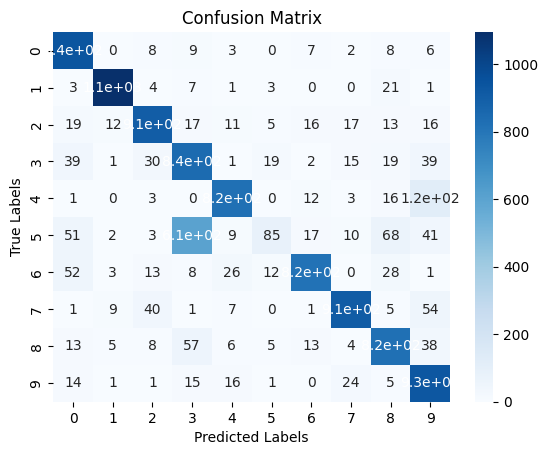

In [212]:

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [213]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets

# Load the MNIST dataset
mnist = datasets.fetch_openml('mnist_784')
X = mnist.data.astype('float32') / 255.0
y = mnist.target.astype('int')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)

# Train the classifier on the training data
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy_sklearn = accuracy_score(y_test, y_pred)
print(f"Accuracy of the sklearn model: {accuracy_sklearn * 100:.2f}%")


C:\Users\Morshedy\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Accuracy of the sklearn model: 97.44%


In [214]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
mnist = datasets.fetch_openml('mnist_784')
X = mnist.data.astype('float32') / 255.0
y = mnist.target.astype('int')

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Create a neural network model
model = Sequential()
model.add(Dense(128, input_dim=784, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
loss, accuracy_Keras = model.evaluate(X_test, y_test)
print(f"Test Accuracy of the Keras model: {accuracy_Keras * 100:.2f}%")


C:\Users\Morshedy\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch 1/10
1575/1575 [==============================] - 7s 4ms/step - loss: 0.2847 - accuracy: 0.9189 - val_loss: 0.1553 - val_accuracy: 0.9557
Epoch 2/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.1248 - accuracy: 0.9633 - val_loss: 0.1089 - val_accuracy: 0.9684
Epoch 3/10
1575/1575 [==============================] - 7s 4ms/step - loss: 0.0852 - accuracy: 0.9743 - val_loss: 0.0939 - val_accuracy: 0.9700
Epoch 4/10
1575/1575 [==============================] - 7s 4ms/step - loss: 0.0635 - accuracy: 0.9806 - val_loss: 0.0878 - val_accuracy: 0.9736
Epoch 5/10
1575/1575 [==============================] - 7s 4ms/step - loss: 0.0492 - accuracy: 0.9847 - val_loss: 0.0799 - val_accuracy: 0.9755
Epoch 6/10
1575/1575 [==============================] - 6s 4ms/step - loss: 0.0384 - accuracy: 0.9881 - val_loss: 0.0742 - val_accuracy: 0.9779
Epoch 7/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 0.0761 - val_accuracy: